In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import numpy as np
sys.path.append(f'../../')

In [3]:
import pandas as pd
from gensim.models import FastText
from src.features.retrofitting import *
from src.data.sentence_vectorizer import SentenceVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaigorodov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kaigorodov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
ft_model = FastText.load_fasttext_format('../../data/external/embeddings/cc.en.300.bin')
ft_model

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [5]:
from copy import deepcopy

def vectorize_sent(sent):
    return np.array([ft_model.wv[w] for w in sent.split()]).mean(axis=0)

def retrofitting(word_vec, lexicons_vecs, iters=1):
    if len(lexicons_vecs) == 0:
        return word_vec
    new_word_vec = deepcopy(word_vec)
    for iteration in range(iters):
        new_word_vec *= len(lexicons_vecs)
        for lexicons_vec in lexicons_vecs:
            new_word_vec += lexicons_vec
        new_word_vec /= 2 * len(lexicons_vecs)
    return new_word_vec

def retrofit_row(row):
    concept = row['STR']
    synonims = set(eval(row['SNMS']))
    concept_vec = vectorize_sent(concept)
    lexicons_vecs = [vectorize_sent(syn) for syn in synonims]
    concept_vec = retrofitting(concept_vec, lexicons_vecs)
    return concept_vec

In [6]:
import tensorflow as tf

# Create train and test sets for NET

In [7]:
from copy import copy

In [34]:
terms_train = pd.read_csv('../../data/interim/smm4h17/train.csv')
terms_test = pd.read_csv('../../data/interim/smm4h17/test.csv')

In [35]:
codes = set(list(set(terms_train['code'].tolist() + terms_test['code'].tolist())))
len(codes)

507

In [36]:


terms_vecs_train = terms_train.apply(lambda row: vectorize_sent(row['term']), axis=1)
terms_vecs_train = pd.DataFrame(terms_vecs_train.values.tolist()).dropna().values

terms_vecs_test = terms_test.apply(lambda row: vectorize_sent(row['term']), axis=1)
terms_vecs_test = pd.DataFrame(terms_vecs_test.values.tolist()).dropna().values

In [37]:
#concepts = pd.read_csv('../../data/interim/used_codes.csv')[['code', 'STR', 'SNMS']]
concepts = pd.read_csv('../../data/interim/used_codes_big.csv')[['code', 'STR', 'SNMS']]

# только те которые есть
#concepts = concepts[concepts['code'].isin(codes)].reset_index(drop=True).reset_index().set_index('code')

# все доступные
#concepts = concepts.reset_index(drop=True).reset_index().set_index('code')

# все из трейна
concepts = concepts[concepts['code'].isin(terms_train['code'])].reset_index(drop=True).reset_index().set_index('code')

codes = concepts['index'].to_numpy()
concepts_vecs = concepts.apply(lambda row: retrofit_row(row), axis=1)
concepts_vecs = pd.DataFrame(concepts_vecs.values.tolist()).dropna().values
codes.shape

(472,)

In [38]:
# concepts_selected = concepts[concepts.index.isin(terms_train['code'])]


# concepts_to_select = concepts[~concepts.index.isin(terms_train['code'])]
# concepts_to_select_vecs = concepts_to_select.apply(lambda row: retrofit_row(row), axis=1)
# concepts_to_select_vecs = pd.DataFrame(concepts_to_select_vecs.values.tolist()).dropna().values

# from src.features.novelty_detector import NoveltyDetector
# nd = NoveltyDetector(n_neighbors=1, contamination=0.5) 

# nd.fit(terms_vecs_train)
# X_novelties, X_not_novelties, novpred = nd.select_novelties(concepts_to_select_vecs)
# np.unique(novpred, return_counts=True)

# concepts_vecs = concepts_vecs[novpred]
# codes = codes[novpred]


# concepts_to_select = concepts_to_select[[True if i ==1 else False for i in novpred]]
# concepts = pd.concat([concepts_selected, concepts_to_select])
# concepts = concepts.reset_index().drop(columns=['index']).reset_index().set_index('code')

# codes = concepts['index'].to_numpy()
# concepts_vecs = concepts.apply(lambda row: retrofit_row(row), axis=1)
# concepts_vecs = pd.DataFrame(concepts_vecs.values.tolist()).dropna().values

In [39]:
terms_codes_train = terms_train['code'].apply(lambda code: concepts.loc[code]['index'])

In [40]:
terms_codes_test = terms_test['code'].apply(
    lambda code: concepts.loc[code]['index'] if code in concepts.index else len(codes)) #OOV CODE
terms_codes_train.max(), terms_codes_test.max()

(471, 472)

In [41]:
terms_codes_train = tf.keras.utils.to_categorical(
    terms_codes_train, num_classes=len(codes)+1, dtype='float32'
)
terms_codes_test = tf.keras.utils.to_categorical(
    terms_codes_test, num_classes=len(codes)+1, dtype='float32'
)

In [42]:
def data_generator(terms_vecs, terms_codes, concepts_vecs, batch_size=50):
    while 1:

        concepts_vecs_choosed = []
        
        index_to_choose = np.random.choice(terms_vecs.shape[0]-batch_size)
        concepts_vecs_choosed.append(concepts_vecs)
            
        terms_vecs_choosed = terms_vecs[index_to_choose:index_to_choose+batch_size]
        terms_codes_choosed = terms_codes[index_to_choose:index_to_choose+batch_size]
        concepts_vecs_choosed = np.array(concepts_vecs_choosed, dtype='float32')
        
        train = [terms_vecs_choosed, concepts_vecs_choosed]
        test = [terms_codes_choosed]
        yield train, test


In [43]:
def cosine_mul_fun(inputs):
    a, b = inputs[0], inputs[1]
    normalize_a = tf.nn.l2_normalize(a,1)        
    normalize_b = tf.nn.l2_normalize(b,1)
    distance = 1 - tf.matmul([normalize_a], normalize_b, transpose_b=True)
    return distance[0]

In [44]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

n_concepts = len(codes)
embedding_size = 300

def get_model():
    inputs1 =    tf.keras.layers.Input(shape=(embedding_size), name='term')
    dn =         tf.keras.layers.Dense(512)(inputs1)
    dn =         tf.keras.layers.Dense(embedding_size)(dn)
    term_hat =   tf.keras.layers.Flatten()(dn)
    inputs2 =    tf.keras.layers.Input(shape=(n_concepts, embedding_size), name='concepts')
    cosine_mul = tf.keras.layers.Lambda(cosine_mul_fun)([term_hat, inputs2])
    activation = tf.keras.layers.ReLU()(cosine_mul)
    output =     tf.keras.layers.Dense(n_concepts+1, activation='softmax')(activation)

    model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=[output])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.001), 
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )
    return model

model = get_model()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term (InputLayer)               [(None, 300)]        0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 512)          154112      term[0][0]                       
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 300)          153900      dense_24[0][0]                   
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 300)          0           dense_25[0][0]                   
____________________________________________________________________________________________

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/80


/home/kaigorodov/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


150/150 - 2s - loss: 3.9804 - categorical_accuracy: 0.2219 - val_loss: 3.2820 - val_categorical_accuracy: 0.4499
Epoch 2/80
150/150 - 1s - loss: 3.3611 - categorical_accuracy: 0.4097 - val_loss: 2.8375 - val_categorical_accuracy: 0.5499
Epoch 3/80
150/150 - 1s - loss: 2.6975 - categorical_accuracy: 0.5413 - val_loss: 2.3432 - val_categorical_accuracy: 0.6005
Epoch 4/80
150/150 - 1s - loss: 2.4618 - categorical_accuracy: 0.5749 - val_loss: 2.1466 - val_categorical_accuracy: 0.6451
Epoch 5/80
150/150 - 1s - loss: 2.2293 - categorical_accuracy: 0.6118 - val_loss: 2.0085 - val_categorical_accuracy: 0.6686
Epoch 6/80
150/150 - 1s - loss: 2.0016 - categorical_accuracy: 0.6511 - val_loss: 1.7790 - val_categorical_accuracy: 0.7044
Epoch 7/80
150/150 - 1s - loss: 1.8278 - categorical_accuracy: 0.6794 - val_loss: 1.7175 - val_categorical_accuracy: 0.7113
Epoch 8/80
150/150 - 1s - loss: 1.6139 - categorical_accuracy: 0.7173 - val_loss: 1.6350 - val_categorical_accuracy: 0.7298
Epoch 9/80
150/150 

 33%|███▎      | 1/3 [01:07<02:15, 67.62s/it]

0.948229193687439 0.8513020873069763
Epoch 1/80
150/150 - 2s - loss: 4.0605 - categorical_accuracy: 0.2155 - val_loss: 3.3612 - val_categorical_accuracy: 0.3868
Epoch 2/80
150/150 - 1s - loss: 3.2149 - categorical_accuracy: 0.4285 - val_loss: 2.8752 - val_categorical_accuracy: 0.4951
Epoch 3/80
150/150 - 1s - loss: 2.8462 - categorical_accuracy: 0.5206 - val_loss: 2.4843 - val_categorical_accuracy: 0.6284
Epoch 4/80
150/150 - 1s - loss: 2.4359 - categorical_accuracy: 0.5801 - val_loss: 2.1347 - val_categorical_accuracy: 0.6659
Epoch 5/80
150/150 - 1s - loss: 2.2123 - categorical_accuracy: 0.6156 - val_loss: 1.9870 - val_categorical_accuracy: 0.6753
Epoch 6/80
150/150 - 1s - loss: 2.0035 - categorical_accuracy: 0.6524 - val_loss: 1.8700 - val_categorical_accuracy: 0.6780
Epoch 7/80
150/150 - 1s - loss: 1.8506 - categorical_accuracy: 0.6793 - val_loss: 1.8079 - val_categorical_accuracy: 0.7020
Epoch 8/80
150/150 - 1s - loss: 1.7133 - categorical_accuracy: 0.7075 - val_loss: 1.6799 - val_

Epoch 67/80
150/150 - 1s - loss: 0.2389 - categorical_accuracy: 0.9529 - val_loss: 1.0516 - val_categorical_accuracy: 0.8465
Epoch 68/80
150/150 - 1s - loss: 0.2279 - categorical_accuracy: 0.9559 - val_loss: 1.0229 - val_categorical_accuracy: 0.8456
Epoch 69/80
150/150 - 1s - loss: 0.2350 - categorical_accuracy: 0.9540 - val_loss: 1.0438 - val_categorical_accuracy: 0.8331
Epoch 70/80
150/150 - 1s - loss: 0.2209 - categorical_accuracy: 0.9567 - val_loss: 0.9862 - val_categorical_accuracy: 0.8504
Epoch 71/80
150/150 - 1s - loss: 0.2119 - categorical_accuracy: 0.9605 - val_loss: 1.0375 - val_categorical_accuracy: 0.8438
Epoch 72/80
150/150 - 1s - loss: 0.2170 - categorical_accuracy: 0.9576 - val_loss: 0.9925 - val_categorical_accuracy: 0.8586
Epoch 73/80
150/150 - 1s - loss: 0.2146 - categorical_accuracy: 0.9584 - val_loss: 1.0183 - val_categorical_accuracy: 0.8530
Epoch 74/80
150/150 - 1s - loss: 0.1907 - categorical_accuracy: 0.9648 - val_loss: 1.0687 - val_categorical_accuracy: 0.8464


 67%|██████▋   | 2/3 [02:35<01:19, 79.80s/it]

0.9653124809265137 0.858593761920929
Epoch 1/80
150/150 - 2s - loss: 4.0258 - categorical_accuracy: 0.2321 - val_loss: 3.2572 - val_categorical_accuracy: 0.4064
Epoch 2/80
150/150 - 1s - loss: 3.2456 - categorical_accuracy: 0.4327 - val_loss: 2.7412 - val_categorical_accuracy: 0.5348
Epoch 3/80
150/150 - 1s - loss: 2.7816 - categorical_accuracy: 0.5278 - val_loss: 2.4358 - val_categorical_accuracy: 0.5996
Epoch 4/80
150/150 - 1s - loss: 2.4597 - categorical_accuracy: 0.5700 - val_loss: 2.1432 - val_categorical_accuracy: 0.6346
Epoch 5/80
150/150 - 1s - loss: 2.1798 - categorical_accuracy: 0.6166 - val_loss: 1.9399 - val_categorical_accuracy: 0.6664
Epoch 6/80
150/150 - 1s - loss: 1.9727 - categorical_accuracy: 0.6527 - val_loss: 1.7573 - val_categorical_accuracy: 0.7033
Epoch 7/80
150/150 - 1s - loss: 1.7947 - categorical_accuracy: 0.6802 - val_loss: 1.7030 - val_categorical_accuracy: 0.7164
Epoch 8/80
150/150 - 1s - loss: 1.6012 - categorical_accuracy: 0.7167 - val_loss: 1.6253 - val_

Epoch 67/80
150/150 - 1s - loss: 0.2325 - categorical_accuracy: 0.9546 - val_loss: 1.0383 - val_categorical_accuracy: 0.8424
Epoch 68/80
150/150 - 1s - loss: 0.2249 - categorical_accuracy: 0.9577 - val_loss: 0.9957 - val_categorical_accuracy: 0.8392
Epoch 69/80
150/150 - 1s - loss: 0.2196 - categorical_accuracy: 0.9593 - val_loss: 1.0160 - val_categorical_accuracy: 0.8424
Epoch 70/80
150/150 - 1s - loss: 0.2169 - categorical_accuracy: 0.9585 - val_loss: 1.0485 - val_categorical_accuracy: 0.8336


100%|██████████| 3/3 [03:51<00:00, 77.29s/it]

0.9593489766120911 0.8506510257720947


('SCORES:', 0.9576302170753479, 0.853515625)

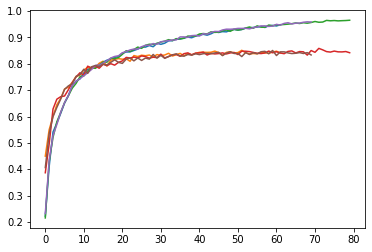

In [45]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_categorical_accuracy",
            min_delta=0,
            patience=10,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )

BATCH_SIZE = 256
train_gen = data_generator(terms_vecs_train, terms_codes_train, concepts_vecs, batch_size=BATCH_SIZE)
test_gen = data_generator(terms_vecs_test, terms_codes_test, concepts_vecs, batch_size=BATCH_SIZE)

train_acc_scores, test_acc_scores = [], []
for iteration in tqdm(range(3)):
    model = get_model()
    
    history = model.fit_generator(train_gen, 
              epochs=80,
              verbose=2,
              steps_per_epoch=150,
              validation_data=test_gen, validation_steps=30,
              callbacks=[early_stopping_callback])

    max_train = np.array(history.history['categorical_accuracy']).max()
    max_val   = np.array(history.history['val_categorical_accuracy']).max()
    train_acc_scores.append(max_train)
    test_acc_scores.append(max_val)
    print(max_train, max_val)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    
"SCORES:", np.array(train_acc_scores).mean(), np.array(test_acc_scores).mean()